# Reinforcement Learning Final Assignment -- Shower Agent
Create a custom OpenAI Gym Environment for a Showering task, including a **Normal** Version Environment and a **Hard** Version Environment. 
Then, solving the environments using one **Tabular Expected SARSA method**, one **Function Approximation method with Q-Learning**, and **Tile Coding Method**.

## Table of Contents:
### 0. Import Libraries

### 1. Normal Version Environment with OpenAI Gym

### 2. Hard Version Environment with OpenAI Gym

### 3. Tabular Method: Backward View Expected SARSA(Lambda)
 -  3.1 Test Normal Environment
 -  3.2 Test Hard Environment

### 4. Function Approximation Method: Q-Learning
   -  4.1 Test Normal Environment
   -  4.2 Test Hard Environment

### 5. Tile Coding
   -  5.1 Test Normal Environment
   -  5.2 Test Hard Environment

# 0. Import Libraries

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# 1. Normal Version Environment with OpenAI Gym

In [2]:
class ShowerEnvNormal(Env):
    def __init__(self):
        # Actions we can take, down, stay, up
        self.action_space = Discrete(3)
        # Temperature array
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        # Set start temp
        self.state = 25 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 180
        
    def step(self, action):
        # Apply action
        # 0 -1 = -1 temperature
        # 1 -1 = 0 
        # 2 -1 = 1 temperature 
        self.state += action -1 
        # Reduce shower length by 1 second
        self.shower_length -= 1 
        
        # Calculate reward
        if self.state >= 36 and self.state <= 39: 
            reward = 1 
        else: 
            reward = -1 
        
        # Check if shower is done
        if self.shower_length <= 0: 
            done = True
        else:
            done = False
        
        # Apply temperature noise
        self.state += random.randint(-1,1)
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset shower temperature
        self.state = 25 + random.randint(-3,3)
        # Reset shower time
        self.shower_length = 180 
        return self.state

In [3]:
env = ShowerEnvNormal()
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-112
Episode:2 Score:-138
Episode:3 Score:-180
Episode:4 Score:-150
Episode:5 Score:-126
Episode:6 Score:-116
Episode:7 Score:-180
Episode:8 Score:-180
Episode:9 Score:-180
Episode:10 Score:-168


/Users/Scofield/anaconda3/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# 2. Hard Version Environment with OpenAI Gym

In [4]:
class ShowerEnvHard(Env):
    def __init__(self):
        # Actions we can take, down, stay, up
        self.action_space = Discrete(3)
        
        # Temperature array
        self.observation_space = Box(low=np.array([0]), high=np.array([100]), dtype=np.float32)
        
        # Set start water temp = state
        self.state = 20 + random.randint(-5,5)
        
        # set initial skin temp = agent don't know
        self.skin_temp = 38 + random.randint(-3,3)
        
        # Set shower length
        self.shower_length = 180
        
    def step(self, action):
        # Apply action
        # 0 -1 = -1 temperature
        # 1 -1 = 0 
        # 2 -1 = 1 temperature 
        
        # keep the state in the range of observation space
        if self.state <= 0 and action == 0:
            self.state += 3*(action + 1)
        elif self.state >= 100 and action == 2:
            self.state -= 0.5*(action + 1)
        else:
            # Since the relationship btw water temp & action on shower dials are non-linear
            # if water temp <= 30, the slope = 3
            # else, the slope = 0.5
            if self.state <= 30:
                self.state += 3*(action - 1)
            else:
                self.state += 0.5*(action - 1)
        
        # the difference btw water temp & skin temp 
        temp_diff = self.state - self.skin_temp
        
        # Water temp will have an impact on skin temp, coeff = 0.05
        self.skin_temp += temp_diff * 0.05
        
        # Reduce shower length by 1 second
        self.shower_length -= 1 
        
        # Calculate reward
        if self.skin_temp >= 36 and self.skin_temp <= 39: 
            reward = 1 
        else: 
            reward = -1 
        
        # Check if shower is done
        if self.shower_length <= 0: 
            done = True
        else:
            done = False
        
        # Apply temperature noise
        # 3 random event changing the water temp
        if np.random.random() <= 0.02:
            self.state += random.randint(-3,3)
        elif np.random.random() <= 0.20:
            self.state += random.randint(-2,2)
        else:
            self.state += random.randint(-1,1)
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset shower temperature
        self.state = 20 + random.randint(-5,5)
        self.skin_temp = 38 + random.randint(-3,3)
        
        # Reset shower time
        self.shower_length = 180 
        return self.state

In [5]:
env = ShowerEnvHard()
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-176
Episode:2 Score:-174
Episode:3 Score:-86
Episode:4 Score:-174
Episode:5 Score:-180
Episode:6 Score:-118
Episode:7 Score:-172
Episode:8 Score:-180
Episode:9 Score:-174
Episode:10 Score:-174


# 3. Tabular Method: Backward View Expected SARSA(Lambda)

In [6]:
class ExpectedSARSALambdaAgent():
    """
    Eaxpected SARSA with eligibility traces.
    """
    def __init__(self, env, gamma, lambda_, alpha, epsilon, epsilon_decay):
        self.env = env
        self.gamma = gamma
        self.lambda_ = lambda_ # "lambda" is a special, protected word in Python, so I add _
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((100,3)) # Action values. Fixed for all objects for this class!
        self.E = np.zeros_like(self.Q) # Eligibility traces. Fixed for all objects for this class!
        self.policy = np.zeros_like(self.Q) # Policy Matrix. Fixed for all objects for this class!

    def choose_action_epsilon_greedy(self, state, epsilon):
        action_values = self.Q[state]
        if np.random.random() < epsilon:
            action = np.random.choice( len(action_values) )
        else:
            action = np.random.choice(np.where(action_values == action_values.max())[0])
        return action

    def run_episode(self, epsilon, episode):
        """
        As in the algorithm in lecture, but the target involves the sum of action
        value available from the state based on the policy, rather than the one actually chosen.
        """
        # initialize for each episode
        self.policy = np.zeros_like(self.Q) 
        self.E = np.zeros_like(self.Q)
        state = self.env.reset()
        action = self.choose_action_epsilon_greedy(state, epsilon)
        done = False
        score = 0 # record cumulative reward

        while not done:
            next_state, reward, done, _ = self.env.step(action)
            next_state = int(round(next_state,0))
            score += reward
            next_action = self.choose_action_epsilon_greedy(next_state, epsilon)
            
            # non-greedy action
            self.policy[next_state] = np.ones(3) * epsilon / 3
            # greedy action
            self.policy[next_state][np.argmax(self.Q[next_state])] = 1 - epsilon + (epsilon / 3)
            # Expected SARSA Target
            target = reward + ( self.gamma * np.sum(self.policy[int(next_state)]*self.Q[next_state]) )
            
            delta = target - self.Q[state][action]
            self.E[state][action] += 1
            self.Q += self.alpha * delta * self.E # update every Q you previous taken!
            self.E *= self.gamma * self.lambda_ # decay!
            state, action = next_state, next_action

        return score # return reward for each episode!

    def learn_task(self, num_episodes):
        """
        This... learns the task.
        """
        #I put this here in case I wanted to use solved episode # as the optimizer target.
        solved = False 
        solved_episode = None

        epsilon = self.epsilon
        self.Q = np.zeros((100,3))
        self.policy = np.zeros_like(self.Q)
        returns = [] # store return!
        avg_100ep_returns = [] # store 100 average return!

        for episode in tqdm( range(1, num_episodes+1), position=0, leave=True ):
            episode_return = self.run_episode(epsilon, episode)
            returns.append(episode_return)
            
            if episode >= 100:
                avg_100ep_returns.append(np.mean(returns[-100:])) # count backward 100, capture most recent 100, sliding window! 

            # Again, the code below is if we wanted to use episode solve index
            # as the hyperparameter search optimization target.
            if (np.mean(returns[-100:]) >= 100) and (solved == False):
                solved_episode = episode

            epsilon *= self.epsilon_decay
        return returns, avg_100ep_returns, solved_episode

## 3.1 Test Normal Environment

In [7]:
# Define hyperparameters
gamma = 0.9 # usually higher
lambda_ = 0.1 # usually lower
epsilon = 1. # Exploration very critical early on. Only way to the goal. 
epsilon_decay = 0.95 # usually higher
alpha = 0.8 # Have to make the most of sparse rewards.
num_episodes = 1000 # large number of episodes

# Create Agent Object
agentNormalTabular = ExpectedSARSALambdaAgent(ShowerEnvNormal(), gamma, lambda_, alpha, epsilon, epsilon_decay)

In [8]:
# Run the episodes
rew, avg, solved_ep = agentNormalTabular.learn_task(num_episodes)

100%|██████████| 1000/1000 [00:14<00:00, 68.92it/s]


Text(0.5, 0.98, 'Tabular Method: Normal Environment')

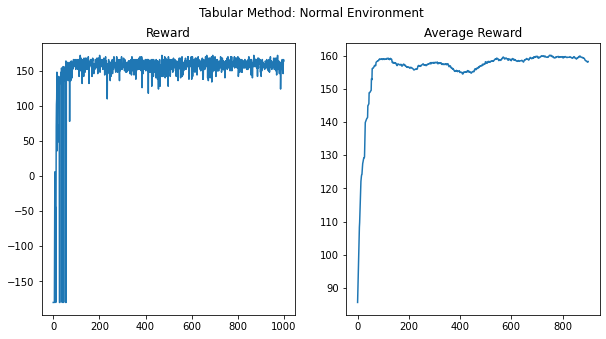

In [9]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Tabular Method: Normal Environment")

## 3.2 Test Hard Environment

In [10]:
# Define hyperparameters
gamma = 0.9 # usually higher
lambda_ = 0.2 # usually lower
epsilon = 1. # Exploration very critical early on. Only way to the goal. 
epsilon_decay = 0.95 # usually higher
alpha = 0.8 # Have to make the most of sparse rewards.
num_episodes = 1000 # large number of episodes

# Create Agent Object
agentHardTabular = ExpectedSARSALambdaAgent(ShowerEnvHard(), gamma, lambda_, alpha, epsilon, epsilon_decay)

In [11]:
# Run the episodes
rew, avg, solved_ep = agentHardTabular.learn_task(num_episodes)

100%|██████████| 1000/1000 [00:16<00:00, 62.25it/s]


Text(0.5, 0.98, 'Tabular Method: Hard Environment')

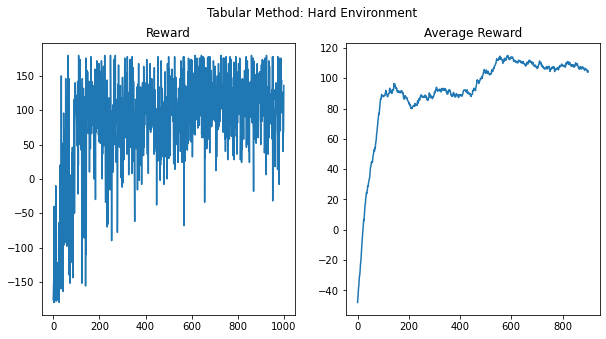

In [12]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Tabular Method: Hard Environment")

# 4. Function Approximation Method: Q-Learning

In [13]:
class LinearQLearner():
    """
    A Linear Q-Learner that just acts greedily all the time. 

    Attributes:
      env : An OpenGym environment
      num_actions : An integer. The number of actions. For convenient reference.
      state_size : An integer. The number of features. For convenient refernece.
      gamma : A float; the discount factor
      alpha : A float; the learning rate.
      epsilon : A float indicating the exploration probability during action
        selection.
      epsilon_decay : A float indicating how much epsilon will be decayed
        between episodes.
      weights : A numpy array (state_size x num_actions) storing the weights.
        This is a stacked representation, in which each action has its own
        weights. For example, the weights for action 0 are stored in column 0,
        the weights for action 1 are stored in column 1 ...

    """

    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay):
        self.env = env
        self.num_actions = self.env.action_space.n
        self.state_size = self.env.observation_space.shape[0]
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.weights = np.zeros(
            (self.state_size, self.env.action_space.n)
        )
    
    def reset(self):
        """
        Resets the weights to 0 for fresh runs.
        """
        self.weights = np.zeros((self.state_size, self.num_actions))

    def estimate_action_values(self, state):
        """
        Arguments:
        state: A numpy array storing the continuous state vector.
        Returns:
        action_values: A numpy array storing the estimated Q values for each 
          action available in the given state.
        """
        action_values = np.dot(
          state, 
          self.weights
          )
        return action_values

    def update_weights(self, delta, state, action):
        """
        Calculates and applies the gradient update to the weights for the chosen
        action.
        Arguments:
            delta: A float; the TD-error.
            state: A numpy array storing the state vector.
            action: An integer; the index of the chosen action.
        """
        delta_vector = np.zeros((1, self.num_actions))
        delta_vector[0,action] = self.alpha * delta
        update =  np.dot(state.T, delta_vector)
        self.weights += update

    def choose_action_epsilon_greedy(self, state, epsilon):
        """
        Chooses an action according to the epsilon-greedy policy.
        Arguments:
            state: A numpy array storing the state vector.
            epsilon: A float; the probabilty to choose a random action.
        Returns:
            action: The index of the chosen action.
            action_value: The vector of Q-values for all available actions.
            action_max: The greedy action (for convenience).
        """
        action_values = self.estimate_action_values(state)
        #print(action_values)
        if np.random.random() < epsilon:
            action = np.random.choice( self.env.action_space.n )
        else:
            action = np.random.choice(np.where(action_values == action_values.max())[0])
        action_value = action_values[0,action]
        action_max = np.max(action_values)
        return action, action_value, action_max

    def run_episode(self, epsilon, episode):
        """
        Runs an epsiode.
        Arguments:
          epsilon: A float; the probability of choosing a random action.
          episode: An integer, the current episode number.
        Returns:
          episode_return: A float. The total reward collected over the episode.
        """
        episode_return = 0
        state = np.array(self.env.reset()).reshape((1,self.state_size))
        done = False

        while not done:
            action, action_value, _ = self.choose_action_epsilon_greedy(state, epsilon)
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.array(next_state).reshape((1,self.state_size))
            next_action, _, max_q = \
                self.choose_action_epsilon_greedy(next_state, epsilon)

            """
            Below, I multiply the gamma*q component by (1-done) because:
            If the episode is done we don't need the gamma*q, so this 
            eliminates that component when we need it to be gone.
            1 - True = 1 - 1 = 0
            1 - False = 1 - 0 = 1
            """
            #target = reward + ( self.gamma * next_action ) * (1-done) # SARSA
            target = reward + ( self.gamma * max_q ) * (1-done) # Q-learning
            delta = target - action_value
            self.update_weights(delta, state, action)
            episode_return += reward
            state = next_state

        return episode_return

    def learn_task(self, num_episodes, print_progress):
        """
        This... learns the task.
        Arguments:
            num_episodes: An integer. The number of episodes to run.
            print_progress: Boolean. Do we want the progress printed as we go?
        Returns:
            returns: A list of the rewards collected from each episode.
            rolling_100_episode_avg: A list of the average of the last 100 episode 
              returns. Starts at episode 101,
        """
        epsilon = self.epsilon
        returns = []
        rolling_100_episode_avg = []

        for episode in tqdm( range(1, num_episodes+1), position=0, leave=True ):
            episode_return = self.run_episode(epsilon, episode)
            returns.append(episode_return)
            if episode > 100:
                avg = sum(returns[episode-100:episode])/100
                rolling_100_episode_avg.append(avg)
                if avg >= 100:
                    print('Solved in {} Episodes!'.format(episode))
                    break
                if print_progress and episode % 100 == 0:
                    print('Average Reward for Last 100 Episodes = {}'.format(avg))

            epsilon *= self.epsilon_decay

        return returns, rolling_100_episode_avg

## 4.1 Test Normal Environment

In [14]:
gamma = 1.
alpha = .00001
epsilon = 0.1
epsilon_decay = .9999

agentNormalFA = LinearQLearner(ShowerEnvNormal(), gamma, alpha, epsilon, epsilon_decay)

In [15]:
rew, avg = agentNormalFA.learn_task(1000, print_progress = False)

100%|██████████| 1000/1000 [00:14<00:00, 67.50it/s]


Text(0.5, 0.98, 'Function Approximation Method: Normal Environment')

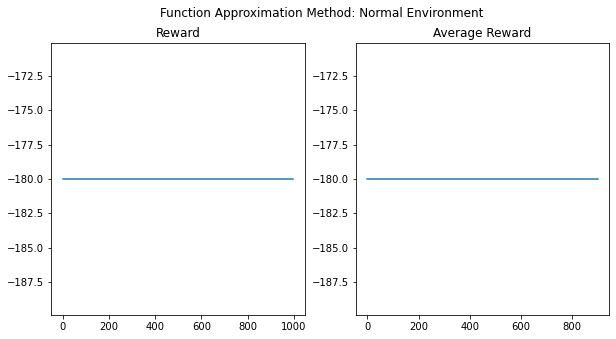

In [16]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Function Approximation Method: Normal Environment")

## 4.2 Test Hard Environment

In [17]:
gamma = 1.
alpha = .00001
epsilon = 0.1
epsilon_decay = .9999

agentHardFA = LinearQLearner(ShowerEnvHard(), gamma, alpha, epsilon, epsilon_decay)

In [18]:
rew, avg = agentHardFA.learn_task(1000, print_progress = False)

100%|██████████| 1000/1000 [00:17<00:00, 56.04it/s]


Text(0.5, 0.98, 'Function Approximation Method: Hard Environment')

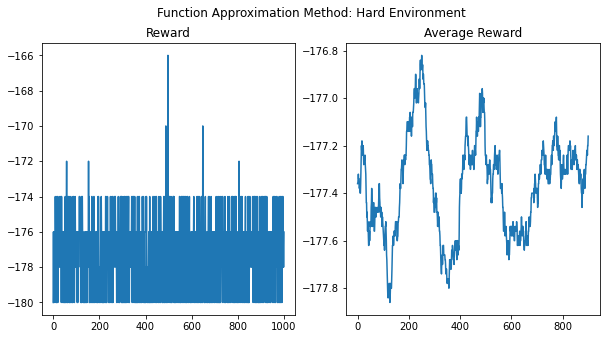

In [19]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Function Approximation Method: Hard Environment")

# 5. Tile Coding

In [20]:
class TileCoder():
    """
    Computes tiles and outputs either the "active feature" indices (i.e., an
    array of integers) or the complete binary vector state representation (i.e., 
    the one-hot vectors for each tiling concatenated into a single big vector).

    Attributes:
      maxNormal: An integer (usually 1). For normalization of the inputs. If 1,
        the inputs are normalized to [0,1]. If 2, [0,2]. And so on.
        
      shape: An integer. The number of features.

      maxVal: A list of length num_features. The maximum values for each feature.

      minVal: A list of length num_features. The minimum values for each feature.

      numTilings: The number of tilings to use.

      tilesPerTiling: The number of tiles for each tiling.

      dim: Integer. The length of maxVal, used as a reference for # of features.

      numTiles: Integer. The number of tiles per tiling.

      actions: Integer. The number of actions.

      n: Integer. The total number of features in the binary vector. Not used by me.

      tileSize: 1 / numTilings. Used in the tile computation in get_features.

    """
    def __init__(self, numTilings, tilesPerTiling, env):
        # Set max value for normalization of inputs
        self.maxNormal = 1
        self.shape = env.observation_space.shape # Number of features?
        self.maxVal = env.observation_space.high # Used for normalization
        self.minVal = env.observation_space.low # Used for normalization
        self.numTilings = numTilings
        self.tilesPerTiling = tilesPerTiling
        self.dim = len(self.maxVal)
        self.numTiles = (self.tilesPerTiling**self.dim) * self.numTilings
        self.actions = env.action_space.n
        self.n = self.numTiles * self.actions
        self.tileSize = np.divide(np.ones(self.dim)*self.maxNormal, self.tilesPerTiling-1)

    def get_features(self, variables):
        """
        Takes in the continuous state representation, returns the indices of
        the active features/tiles.

        Ensures range is always between 0 and self.maxValue.

        Arguments:
          variables: A numpy array of floats storing the continuous state vector.
        Returns:
          tileIndices: A numpy array of integers storing the indices of active tiles.
        """
        values = np.zeros(self.dim)
        for i in range(len(self.shape)):
            values[i] = self.maxNormal * ((variables[i] - self.minVal[i])/(self.maxVal[i]-self.minVal[i])) # Normalize range 0-1
        tileIndices = np.zeros(self.numTilings)
        matrix = np.zeros([self.numTilings,self.dim])
        for i in range(self.numTilings):
            for i2 in range(self.dim):
                matrix[i,i2] = int(values[i2] / self.tileSize[i2] + i / self.numTilings)
        for i in range(1,self.dim):
            matrix[:,i] *= self.tilesPerTiling**i
        for i in range(self.numTilings):
            tileIndices[i] = (i * (self.tilesPerTiling**self.dim) + sum(matrix[i,:])) 
        return tileIndices.astype(int)

    def one_hot_vector(self, indices):
        """
        Takes in the indices of active tiles, returns the long binary vector
        of concatenated one-hot vectors.

        Arguments:
        indices: A numpy array of ints storing the indices of active tiles.
        Returns:
        binary_vector: A numpy array of 0s and 1s, with each active tile set 
          to 1 (all others 0).
        """
        binary_vector = np.zeros((self.numTiles,1))
        
        for i, item in enumerate(indices):
            if item >= (len(binary_vector)-1):
                indices[i] = (len(binary_vector)-1)
        
        binary_vector[indices] = 1
        return binary_vector

In [21]:
class LinearTileCodedQLearner():
    """
    The same linear learner as before, but this time equipped with a tile coder.

    Attributes:
        env: An OpenGym env instance
        num_actions: An integer. The number of actions (for convenience).
        num_tilings: An integer. The number of tilings.
        tiles_per_tiling: An integer. The number of tiles per tiling used. 
        tile_coder: A TileCoder instance, instantiated with num_tilings and tiles_per_tiling.
        alpha: A float; the learning rate. Divided the the number of tilings as in the text.
        weights: A numpy array storing the model weights. Of shape (num_features,num_actions).
          The number of features = number of tilings * tiles per tiling.
    """
    def __init__(self, env, gamma, alpha, num_tilings, tiles_per_tiling):
        self.env = env
        self.num_actions = self.env.action_space.n # For convenience
        self.gamma = gamma
        self.tile_coder = TileCoder(
            numTilings = num_tilings, 
            tilesPerTiling = tiles_per_tiling, 
            env = self.env
            )
        # Set alpha roughly according to advice on pg 220 of text.
        self.alpha = (alpha/ num_tilings)

        # Weights initialized to zero because the reward is constantly -1;
        # zero is actually an "optimistic initial value" and guarantees 
        # sufficient exploration.
        self.weights = np.zeros((self.tile_coder.numTiles, self.num_actions))

    def reset(self):
        self.weights = np.zeros((self.tile_coder.numTiles, self.num_actions))

    def update_weights(self, delta, encoded_state, action):
        delta_vector = np.zeros((1, self.num_actions))
        delta_vector[0,action] = delta
        update = self.alpha * np.dot(encoded_state, delta_vector)
        self.weights += update

    def run_episode(self, episode):
        """
        As before, but no epsilon because we don't need itttttt
        """
        G = 0
        state = self.env.reset()
        done = False

        while not done:
            encoded_state = self.tile_coder.one_hot_vector(
                self.tile_coder.get_features(np.array(state).reshape(-1))
            )
            Q = np.dot(encoded_state.T,self.weights).reshape(-1)
            action = np.argmax(Q)
            next_state, reward, done, _ = self.env.step(action)
            G += reward

            encoded_next_state = self.tile_coder.one_hot_vector(
                self.tile_coder.get_features(np.array(next_state).reshape(-1))
            )
            next_Q = np.dot(encoded_next_state.T,self.weights).reshape(-1)
            delta = reward + (self.gamma * np.max(next_Q) * (1-done)) - Q[action]
            self.update_weights(delta, encoded_state, action)
            state = next_state

        return G

    def learn_task(self, num_episodes, print_progress):
        returns = []
        rolling_100_episode_avg = []

        for episode in tqdm( range(1, num_episodes+1), position=0, leave=True):
            episode_return = self.run_episode(episode)
            returns.append(episode_return)
            if episode > 100:
                avg = sum(returns[episode-100:episode])/100
                rolling_100_episode_avg.append(avg)
                
                # agent can solve the environment very quickly
                # so I comment the following 3 lines out to produce the reward plots
                #if avg >= 100:    
                    #print('Solved in {} Episodes!'.format(episode))
                    #break
                if print_progress and episode % 100 == 0:
                    print('Average Reward for Last 100 Episodes = {}'.format(avg))
        
        return returns, rolling_100_episode_avg

## 5.1 Test Normal Environment

In [22]:
gamma = 0.95
alpha = 0.95
num_tilings = 3 
tiles_per_tiling = 9

agent = LinearTileCodedQLearner(ShowerEnvNormal(), gamma, alpha, num_tilings, tiles_per_tiling)

In [23]:
rew, avg = agent.learn_task(2000, print_progress = False)

100%|██████████| 2000/2000 [00:43<00:00, 46.20it/s]


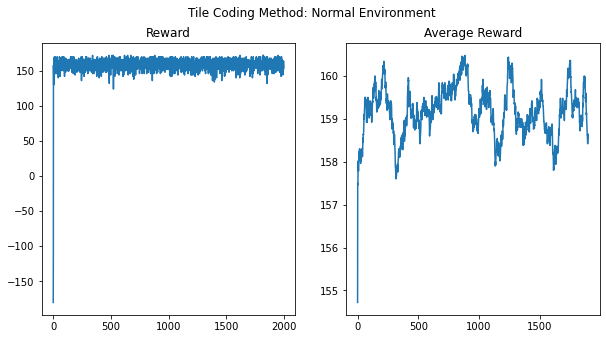

In [24]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Tile Coding Method: Normal Environment")

agent.reset()

## 5.2 Test Hard Environment

In [25]:
gamma = 0.96
alpha = 0.96
num_tilings = 2
tiles_per_tiling = 16

agent_tile_2 = LinearTileCodedQLearner(ShowerEnvHard(), gamma, alpha, num_tilings, tiles_per_tiling)

In [26]:
rew, avg = agent_tile_2.learn_task(2000, print_progress = False)

100%|██████████| 2000/2000 [00:40<00:00, 48.87it/s]


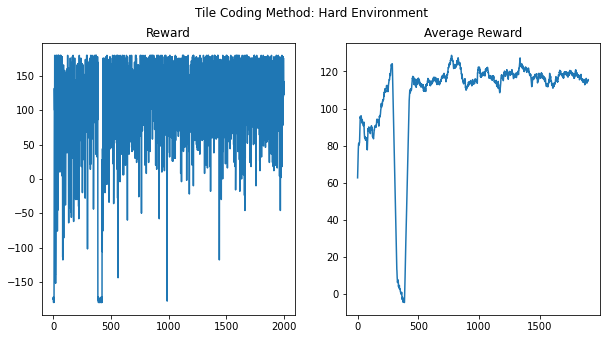

In [27]:
# Show results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(rew)
ax1.set_title("Reward")
ax2.plot(avg)
ax2.set_title("Average Reward")
fig.suptitle("Tile Coding Method: Hard Environment")

agent_tile_2.reset()